# セマンティックセグメンテーション

## 今回のタスク
セマンティックセグメンテーション（Semantic Segmentation）<br>
画像のピクセル（画素）1つひとつに対してラベル付けしていく手法<br>
<img src="img/semantic_segmentation.png" width="800"></img>

### 使用するモデル：UNet
- 医療画像解析に特に強みを持つエンコーダ・デコーダ構造のネットワークです。
- 特徴マップの空間情報を保持しながら高精度なセグメンテーションが可能で、様々な分野で利用されています。
- シンプルな構造で拡張が容易なため、多クラスセグメンテーションにも適用されています。
<img src="img/unet.png" width="800"></img>

### 損失関数：Dice Cross-Entropy Loss
- ダイス損失（Dice Loss）とクロスエントロピー損失を足し合わせた損失関数
$$Dice Loss = 1 - \frac{2|A \cap B|}{|A| + |B|}$$
<img src='img/dice_loss.png' width=800></img><br>
$$Cross Entropy Loss = -\frac{1}{N}\sum_{i=1}^Np(x)\log{q(x)}$$
<img src='img/cross_entropy.png' width=800></img><br>

## 準備

### ライブラリのインポート

In [1]:
import os
import math
import tqdm
import torch
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader


from pspnet import PSPNet
from dataset import VOCDataset
from util import DiceCrossEntropyLoss

### カラーパレット

In [3]:
# VOC2012で用いるラベル
CLASSES = ['backgrounds','aeroplane','bicycle','bird','boat','bottle',
            'bus','car' ,'cat','chair','cow', 
            'diningtable','dog','horse','motorbike','person', 
            'potted plant', 'sheep', 'sofa', 'train', 'monitor','unlabeld'
            ]

# カラーパレットの作成
COLOR_PALETTE = np.array(Image.open("./VOCdevkit/VOC2012_sample/SegmentationClass/2007_000170.png").getpalette()).reshape(-1,3)
COLOR_PALETTE = COLOR_PALETTE.tolist()[:len(CLASSES)]

In [ ]:
# カラーパレットの可視化
fig, axes_list = plt.subplots(len(CLASSES), 1, figsize=(5, 10))
for i, color in enumerate(COLOR_PALETTE[:len(CLASSES)]):
    color_img = np.full((1, 10, 3), color, dtype=np.uint8)

    axes_list[i].imshow(color_img, aspect='auto')
    axes_list[i].set_axis_off()
    axes_list[i].text(-1, 0, f'{i}: {CLASSES[i]}', va='center', ha='right', fontsize=10)
    
plt.show()

今回はこのカラーパレットの通りに識別ができるように訓練を行います。

### 画像サンプル

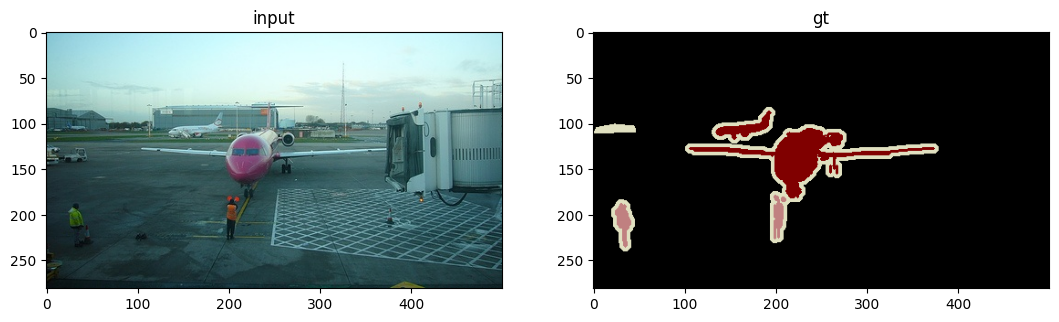

In [4]:
# 入力画像・出力画像の例
input = Image.open('VOCdevkit/VOC2012_sample/JPEGImages/2007_000032.jpg')
gt = Image.open('VOCdevkit/VOC2012_sample/SegmentationClass/2007_000032.png')
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2,3,1).set_title('input')
plt.imshow(input)
fig.add_subplot(2,3,2).set_title('gt')
plt.imshow(gt)
plt.show()

### データセット・データローダー

In [4]:
# データのリストファイル
train_list_path = 'VOCdevkit/VOC2012_sample/listfile/train_list_300.txt'
val_list_path = 'VOCdevkit/VOC2012_sample/listfile/val_list_100.txt'

# データディレクトリ
img_dir = 'VOCdevkit/VOC2012_sample/JPEGImages'
gt_dir = 'VOCdevkit/VOC2012_sample/SegmentationClass'

In [5]:
# リストファイルの読み込み
with open(train_list_path, 'r') as f:
    train_list = f.read().splitlines()
with open(val_list_path, 'r') as g:
    val_list = g.read().splitlines()

In [6]:
# データセットの作成
train_ds = VOCDataset(img_list=train_list, img_dir=img_dir, gt_dir=gt_dir, data_augmentation=False)
val_ds = VOCDataset(img_list=val_list, img_dir=img_dir, gt_dir=gt_dir)
print(f"len(train_data): {train_ds.__len__()}")
print(f"len(test_data): {val_ds.__len__()}")

# データローダーの作成
train_dl = DataLoader(train_ds, batch_size=16, num_workers=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=8, shuffle=True)

len(train_data): 300
len(test_data): 100


### 関数

In [ ]:
# 訓練
def train(dataloader, model, optimizer, criterion, device):
    model.train()
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    step_total = math.ceil(size/batch_size)
    total_loss = 0.0

    with tqdm.tqdm(enumerate(dataloader), total=step_total) as pbar:
        for batch, item in pbar:
            inp, gt = item[0].to(device), item[1].to(device)

            # 推論
            pred = model(inp)

            # 損失誤差を計算
            loss = criterion(pred, gt)
            total_loss += loss.item()

            # バックプロパゲーション
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # プログレスバーに損失を表示
            pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / step_total
        print(f"Train Loss: {avg_loss:.4f}")
    return avg_loss

# テスト
def test(dataloader, model, criterion, device):
    model.eval()
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    step_total = math.ceil(size/batch_size)
    total_loss = 0.0

    with torch.no_grad():
        for item in dataloader:
            inp, gt = item[0].to(device), item[1].to(device)
            pred = model(inp)
            loss = criterion(pred, gt)
            total_loss += loss.item()

        avg_loss = total_loss / step_total
        print(f"Val Loss: {avg_loss:.4f}")
    return avg_loss

# 推論結果の可視化
def visualize(model, img_id, img_dir, gt_dir, criterion, device='cpu'):
    img_path = os.path.join(img_dir, img_id) + ".jpg"
    gt_path = os.path.join(gt_dir, img_id) + ".png"
    class_values = [CLASSES.index(cls.lower()) for cls in CLASSES]
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        # 入力画像の前処理 (PIL画像 -> Tensor)
        inp_tensor = transforms.functional.to_tensor(Image.open(img_path))
        inp_resized = transforms.Resize(size=(256, 256))(inp_tensor)
        inp_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inp_resized)
        inp = inp_normalized.unsqueeze(0)

        # 正解画像の前処理 (PIL画像 -> NumPy -> Tensor)
        gt_np = np.asarray(Image.open(gt_path))
        gt_np = np.where(gt_np == 255, 0, gt_np)  # 範囲外の255を0に置換（または別のインデックスに）

        gt_tensor = torch.tensor(gt_np, dtype=torch.long)
        gt_tensor = gt_tensor.unsqueeze(0)
        gt_resized = transforms.Resize(size=(256, 256))(gt_tensor)

        # 予測
        pred, pred_aux = model(inp)
        # loss = criterion(pred, gt_resized) # loss計算
        # print(f'Loss: {loss.item()}')

        inp_np = (inp_resized.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)  # 表示用スケール
        pred_np = torch.argmax(pred, dim=1).cpu().detach().numpy()[0]
        pred_np = np.clip(pred_np, 0, len(COLOR_PALETTE) - 1).astype(np.int32)
        gt_resized = gt_resized.squeeze(0).detach().numpy().astype(np.int32)

        # カラーパレットの適用
        img_gt = np.array([[COLOR_PALETTE[gt_resized[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)
        img_pred = np.array([[COLOR_PALETTE[pred_np[i, j]] for j in range(256)] for i in range(256)], dtype=np.uint8)

    # プロット
    fig = plt.figure(figsize=(16, 10))
    for i, im in enumerate([inp_np, img_gt, img_pred]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(im)
        ax.set_title(["Input", "Ground Truth", "Prediction"][i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## 訓練

### 設定

In [2]:
initial_epoch = 0 # ここは変えない
epochs = 10 # エポック
lr = 0.01 # 学習率

device = 'cuda' if torch.cuda.is_available() else "cpu" # デバイスの設定
print("Using {} device".format(device))

model = PSPNet(n_classes=22) # モデル
model = model.to(device)

weight = None # torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5]) # クロスエントロピー損失のクラスごとの重み
dice_weight = 0.5 # 損失のうち、Dice Lossの比率

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 最適化手法

save_model_n = None # 5 # 重みを保存する頻度（＊容量を圧迫する可能性があるので小さくしすぎないよう注意！！クラスターであれば気にしなくてOK。）
save_dir = './your_save_dir' # 訓練ログ保存ディレクトリ
save_name_prefix = 'your_save_name' # 訓練ログ保存名
csv_path = os.path.join(save_dir, f'{save_name_prefix}.csv')

chkp_path = None # 'weights/unet_241106_00.pth' # 重みの初期値
continuation = False # 訓練を続きから再開する場合True

Using cuda device


In [8]:
# 保存ディレクトリの作成
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 重みの読み込み。
if chkp_path is not None:
    checkpoint = torch.load(chkp_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    if continuation == True:
        initial_epoch = checkpoint["epoch"] + 1

if weight is not None:
    weight = weight.to(device)
criterion =  DiceCrossEntropyLoss(weight=weight, dice_weight=dice_weight) # 損失関数

for epoch in range(initial_epoch, epochs):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loss = train(train_dl, model, optimizer, criterion, device)
    val_loss = test(val_dl, model, criterion, device)
    if save_model_n is not None:
        if epoch == save_model_n-1:
            # モデルの重みを保存
            torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                },
            os.path.join(save_dir, f'{save_name_prefix}_ep{epoch}.pth'),
            )
            save_model_n += save_model_n
    # 訓練ログ記入
    if not os.path.exists(csv_path):
        with open(csv_path, 'w') as f:
            f.write('epoch,train_loss,val_loss\n')
    with open(csv_path, 'a') as f:
        f.write(f'{epoch},{train_loss},{val_loss}\n')

Epoch 0
-------------------------------


  0%|          | 0/19 [00:00<?, ?it/s]


TypeError: PSPNet.forward() takes 1 positional argument but 2 were given

## 可視化

### 損失のプロット

In [ ]:
log_df = pd.read_csv(csv_path)
plt.plot(log_df['epoch'], log_df['train_loss'], label='trian_data')
plt.plot(log_df['epoch'], log_df['val_loss'], label='test_data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.ylim(0,2.0)

### 推論結果

<b>train data</b>

In [ ]:
img_id = '2007_000032'
visualize(model, img_id, img_dir, gt_dir, criterion)

In [ ]:
img_id = '2007_000648'
visualize(model, img_id, img_dir, gt_dir, criterion)

In [ ]:
img_id = '2007_001225'
visualize(model, img_id, img_dir, gt_dir, criterion)

In [ ]:
img_id = '2007_002488'
visualize(model, img_id, img_dir, gt_dir, criterion)

<b>test data</b>

In [ ]:
img_id = '2007_000033'
visualize(model, img_id, img_dir, gt_dir, criterion)

In [ ]:
img_id = '2007_001763'
visualize(model, img_id, img_dir, gt_dir, criterion)

In [ ]:
img_id = '2007_003367'
visualize(model, img_id, img_dir, gt_dir, criterion)